In [1]:
import sys
import pandas as pd
import ast
import os
import pickle
from torch.utils.data import DataLoader
import anndata as ad
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import seaborn as sns
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())

sys.path.append('../src/null-effect-net')
import utils
import models
import dataset

In [2]:
active_nodes_df = pd.read_csv('../data/expression_reference/expression_reference.csv', index_col=0)
#node_features_df = pd.read_csv('../data/embeddings.csv', index_col=0)
with open('../data/embeddings.pkl', 'rb') as f:
    node_features_df = pickle.load(f)

node_features_df['Concat Embedding'] = node_features_df['ESM Embedding'] + node_features_df['SubCell Embedding'] + node_features_df['PINNACLE Embedding']
node_features_df

,Ensembl ID,ESM Embedding,SubCell Embedding,PINNACLE Embedding,Concat Embedding
0,ENSG00000167034,"[0.0028145362823023164, 0.0005299595216486408,...","[0.002200696862015164, -0.0022003327834128417,...","[0.02840029120032928, 0.03849968745048708, 0.1...","[0.0028145362823023164, 0.0005299595216486408,..."
1,ENSG00000166337,"[-0.004688626909047148, -0.018935436949676598,...","[0.005328961307645572, -0.0022332685330640843,...","[0.05953141022201005, 0.08082420457555971, 0.1...","[-0.004688626909047148, -0.018935436949676598,..."
2,ENSG00000079134,"[0.001339098611411978, -0.0008965306251028483,...","[0.001145576645861274, -0.0018833219692092947,...","[0.06436410165298277, 0.0404357684641299, -0.0...","[0.001339098611411978, -0.0008965306251028483,..."
3,ENSG00000162222,"[0.0035497682908138604, -1.3937270266465224e-0...","[0.0021583817606795975, -0.00258905808071088, ...","[0.05372116385830175, 0.02595721685784264, 0.2...","[0.0035497682908138604, -1.3937270266465224e-0..."
4,ENSG00000117036,"[-0.0001993696037519223, -0.013870936954973916...","[0.0016716711263733547, -0.002096006052993096,...","[-0.008349455598281492, -0.01541616074484265, ...","[-0.0001993696037519223, -0.013870936954973916..."
...,...,...,...,...,...
9304,ENSG00000073050,"[0.004195602026609745, -0.01895238077701169, -...","[0.0021818315247462542, -0.0009692755641472429...","[0.055912777750702095, -0.007035643094679399, ...","[0.004195602026609745, -0.01895238077701169, -..."
9305,ENSG00000175691,"[-0.006420728323922411, 0.0018827187241085425,...","[0.0035715817298381776, -0.0009964322411038444...","[-0.011887651512804947, -0.01274934496608555, ...","[-0.006420728323922411, 0.0018827187241085425,..."
9306,ENSG00000152056,"[0.004283052656760009, 0.015064213032876422, -...","[0.004038620209858725, -0.0015329866763180964,...","[0.08778504133007874, 0.0010841354941502634, 0...","[0.004283052656760009, 0.015064213032876422, -..."
9307,ENSG00000182446,"[0.008511807445938149, -0.0072194453712633565,...","[0.0031762134175250005, -0.0023738711469537916...","[0.16810925843645932, 0.04216538941421464, 0.0...","[0.008511807445938149, -0.0072194453712633565,..."


## Compile datapoints with labels

In [3]:
processed_folder = '../data/perturbation_screens/e_distance'
metric = 'e_distances'

all_dfs = []

for file in os.listdir(processed_folder):

    if file not in ['test.csv', 'train.csv']:

        df = pd.read_csv(os.path.join(processed_folder, file), index_col=0)
        df['experiment'] = file[:file.find(metric)]
        all_dfs.append(df)

all_df = pd.concat(all_dfs)
all_df

,perturbation,e_distance,p_value,experiment
0,ENSG00000005339,0.193873,0.008,TianKampmann2021_CRISPRi_
1,ENSG00000154447,0.199291,0.612,TianKampmann2021_CRISPRi_
2,ENSG00000147133,0.100834,0.194,TianKampmann2021_CRISPRi_
3,ENSG00000168246,0.204343,0.040,TianKampmann2021_CRISPRi_
4,ENSG00000151474,4.298759,0.000,TianKampmann2021_CRISPRi_
...,...,...,...,...
21,ENSG00000104687,0.172275,0.844,TianKampmann2019_iPSC_
22,ENSG00000138621,0.100192,0.356,TianKampmann2019_iPSC_
23,ENSG00000110955,0.657193,0.008,TianKampmann2019_iPSC_
24,ENSG00000104549,0.111362,0.988,TianKampmann2019_iPSC_


## Rename if necessary

In [4]:
all_df.rename({'perturbation': 'Target'}, inplace=True, axis=1)
all_df

,Target,e_distance,p_value,experiment
0,ENSG00000005339,0.193873,0.008,TianKampmann2021_CRISPRi_
1,ENSG00000154447,0.199291,0.612,TianKampmann2021_CRISPRi_
2,ENSG00000147133,0.100834,0.194,TianKampmann2021_CRISPRi_
3,ENSG00000168246,0.204343,0.040,TianKampmann2021_CRISPRi_
4,ENSG00000151474,4.298759,0.000,TianKampmann2021_CRISPRi_
...,...,...,...,...
21,ENSG00000104687,0.172275,0.844,TianKampmann2019_iPSC_
22,ENSG00000138621,0.100192,0.356,TianKampmann2019_iPSC_
23,ENSG00000110955,0.657193,0.008,TianKampmann2019_iPSC_
24,ENSG00000104549,0.111362,0.988,TianKampmann2019_iPSC_


## Filter for nodes with embeddings

In [5]:
nodes_with_embeddings = list(node_features_df['Ensembl ID'].unique())

all_df = all_df[all_df['Target'].isin(nodes_with_embeddings)]
active_nodes_df = active_nodes_df[active_nodes_df['Gene'].isin(nodes_with_embeddings)]
all_df = all_df.reset_index(drop=True)
all_df

,Target,e_distance,p_value,experiment
0,ENSG00000005339,0.193873,0.008,TianKampmann2021_CRISPRi_
1,ENSG00000154447,0.199291,0.612,TianKampmann2021_CRISPRi_
2,ENSG00000147133,0.100834,0.194,TianKampmann2021_CRISPRi_
3,ENSG00000151474,4.298759,0.000,TianKampmann2021_CRISPRi_
4,ENSG00000114867,0.214418,0.096,TianKampmann2021_CRISPRi_
...,...,...,...,...
3971,ENSG00000143374,0.171191,0.670,TianKampmann2019_iPSC_
3972,ENSG00000104687,0.172275,0.844,TianKampmann2019_iPSC_
3973,ENSG00000138621,0.100192,0.356,TianKampmann2019_iPSC_
3974,ENSG00000110955,0.657193,0.008,TianKampmann2019_iPSC_


In [6]:
all_df['experiment'].unique()

array(['TianKampmann2021_CRISPRi_',
       'ReplogleWeissman2022_K562_essential_',
       'TianKampmann2019_day7neuron_', 'GasperiniShendure2019_lowMOI_',
       'ReplogleWeissman2022_rpe1_', 'FrangiehIzar2021_RNA_',
       'TianKampmann2019_iPSC_'], dtype=object)

## Add Cell Type Info

In [7]:
cell_line_map = {
    'TianKampmann2021_CRISPRi_': 'iPSC-induced neuron', 
    'ReplogleWeissman2022_K562_essential_': 'K562', 
    'TianKampmann2019_day7neuron_': 'iPSC-induced neuron',
    'GasperiniShendure2019_lowMOI_': 'K562',
    'ReplogleWeissman2022_rpe1_': 'RPE1',
    'FrangiehIzar2021_RNA_': 'melanocytes',
    'TianKampmann2019_iPSC_': 'iPSC',
    'GasperiniShendure2019_atscale_': 'K562',
    'ReplogleWeissman2022_K562_gwps_': 'K562',
    }

In [8]:
df_expr_ref = pd.read_csv('../data/expression_reference/expression_reference.csv', index_col=0)
df_expr_ref

,Cell Line,Gene
0,K562,ENSG00000000003
1,K562,ENSG00000000419
2,K562,ENSG00000000457
3,K562,ENSG00000000460
4,K562,ENSG00000000938
...,...,...
14969,iPSC,ENSG00000286522
14970,iPSC,ENSG00000287080
14971,iPSC,ENSG00000288558
14972,iPSC,ENSG00000288637


In [9]:
all_df['Cell Line'] = all_df['experiment'].map(cell_line_map)
all_df

,Target,e_distance,p_value,experiment,Cell Line
0,ENSG00000005339,0.193873,0.008,TianKampmann2021_CRISPRi_,iPSC-induced neuron
1,ENSG00000154447,0.199291,0.612,TianKampmann2021_CRISPRi_,iPSC-induced neuron
2,ENSG00000147133,0.100834,0.194,TianKampmann2021_CRISPRi_,iPSC-induced neuron
3,ENSG00000151474,4.298759,0.000,TianKampmann2021_CRISPRi_,iPSC-induced neuron
4,ENSG00000114867,0.214418,0.096,TianKampmann2021_CRISPRi_,iPSC-induced neuron
...,...,...,...,...,...
3971,ENSG00000143374,0.171191,0.670,TianKampmann2019_iPSC_,iPSC
3972,ENSG00000104687,0.172275,0.844,TianKampmann2019_iPSC_,iPSC
3973,ENSG00000138621,0.100192,0.356,TianKampmann2019_iPSC_,iPSC
3974,ENSG00000110955,0.657193,0.008,TianKampmann2019_iPSC_,iPSC


## Binarize

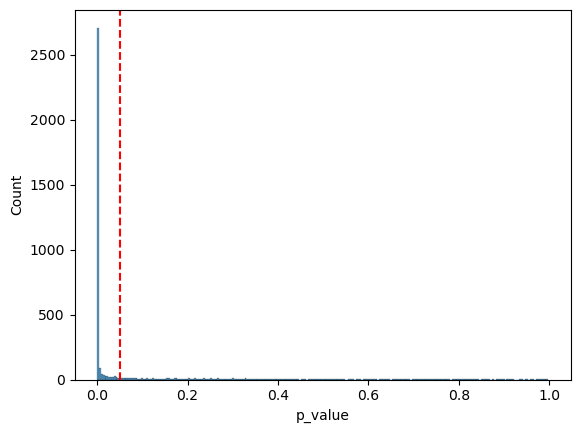

In [10]:
sns.histplot(all_df, x='p_value')
plt.axvline(x=0.05, color='red', linestyle='--')

In [11]:
all_df['Perturbed'] = all_df['p_value'] < 0.05
all_df

,Target,e_distance,p_value,experiment,Cell Line,Perturbed
0,ENSG00000005339,0.193873,0.008,TianKampmann2021_CRISPRi_,iPSC-induced neuron,True
1,ENSG00000154447,0.199291,0.612,TianKampmann2021_CRISPRi_,iPSC-induced neuron,False
2,ENSG00000147133,0.100834,0.194,TianKampmann2021_CRISPRi_,iPSC-induced neuron,False
3,ENSG00000151474,4.298759,0.000,TianKampmann2021_CRISPRi_,iPSC-induced neuron,True
4,ENSG00000114867,0.214418,0.096,TianKampmann2021_CRISPRi_,iPSC-induced neuron,False
...,...,...,...,...,...,...
3971,ENSG00000143374,0.171191,0.670,TianKampmann2019_iPSC_,iPSC,False
3972,ENSG00000104687,0.172275,0.844,TianKampmann2019_iPSC_,iPSC,False
3973,ENSG00000138621,0.100192,0.356,TianKampmann2019_iPSC_,iPSC,False
3974,ENSG00000110955,0.657193,0.008,TianKampmann2019_iPSC_,iPSC,True


In [12]:
print(f"Percentage perturbed: {all_df['Perturbed'].sum() / len(all_df)}")

Percentage perturbed: 0.767354124748491


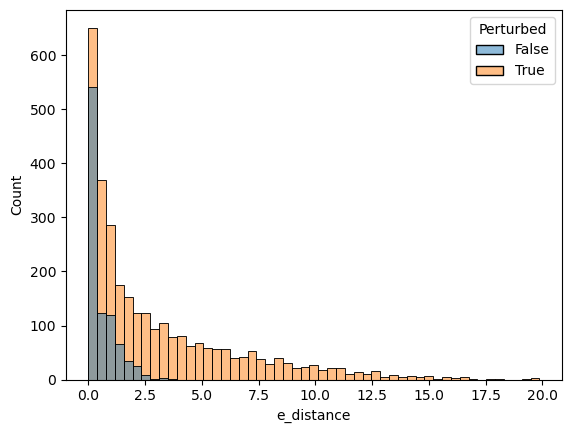

In [14]:
sns.histplot(all_df, x='e_distance', hue='Perturbed')
plt.savefig('../figures/preprocessing/e_distance.svg', dpi=400)

## log transform distance

Lambda: 0.03760411325835404


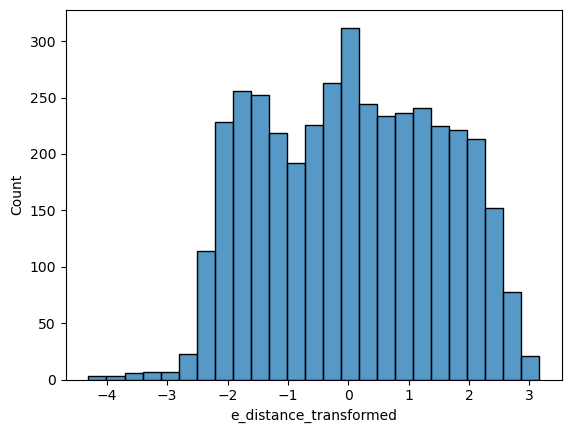

In [16]:
all_df['e_distance_transformed'], lmbda = boxcox(all_df['e_distance'] + 1e-6)
sns.histplot(all_df, x='e_distance_transformed')
print(f'Lambda: {lmbda}')

## Scramble

In [17]:
all_df = all_df.sample(frac=1)
all_df

,Target,e_distance,p_value,experiment,Cell Line,Perturbed,e_distance_transformed
3290,ENSG00000176407,1.441460,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,0.368183
2619,ENSG00000168876,0.517026,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,-0.651546
2642,ENSG00000115268,3.966061,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,1.414089
1691,ENSG00000241468,2.367709,0.770000,GasperiniShendure2019_lowMOI_,K562,False,0.876044
728,ENSG00000185085,4.818220,0.001996,ReplogleWeissman2022_K562_essential_,K562,True,1.619822
...,...,...,...,...,...,...,...
51,ENSG00000108578,0.192178,0.324000,TianKampmann2021_CRISPRi_,iPSC-induced neuron,False,-1.599220
1330,ENSG00000183495,5.761626,0.001996,ReplogleWeissman2022_K562_essential_,K562,True,1.810168
2827,ENSG00000127804,1.658460,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,0.510732
1184,ENSG00000126461,1.188598,0.001996,ReplogleWeissman2022_K562_essential_,K562,True,0.173338


## Split

In [18]:
train_df = all_df.iloc[:int(0.8*len(all_df)), :]
test_df = all_df.iloc[int(0.8*len(all_df)):, :]
print(f'{len(train_df)=}')
print(f'{len(test_df)=}')
print(f"{sum(train_df['Perturbed'])/len(train_df)=}")
print(f"{sum(test_df['Perturbed'])/len(test_df)=}")

len(train_df)=3180
len(test_df)=796
sum(train_df['Perturbed'])/len(train_df)=0.7682389937106918
sum(test_df['Perturbed'])/len(test_df)=0.7638190954773869


In [19]:
train_df.to_csv(f'{processed_folder}/train.csv')
test_df.to_csv(f'{processed_folder}/test.csv')